# Analyzing DTM Results
#https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb

In [1]:
import pickle
import pyLDAvis
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.special import logsumexp
import scipy as sp
from collections import OrderedDict, defaultdict

#set precision for pandas
pd.set_option("display.precision", 10)
 

# Set topic number

In [2]:
model = pickle.load(open("/Users/carlyknight/Documents/Data/FuturePerfect/dynamic_topic_models/topic_para_futonly_10.pkl", "rb" ) )
#print model attirbutes
print(model.__dict__.keys())

/Users/carlyknight/anaconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
/Users/carlyknight/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


dict_keys(['dtm_path', 'id2word', 'num_terms', 'num_topics', 'lencorpus', 'prefix', 'time_slices', 'lda_sequence_min_iter', 'lda_sequence_max_iter', 'lda_max_em_iter', 'alpha', 'top_chain_var', 'rng_seed', 'initialize_lda', 'lambda_', 'obs_', 'lhood_', 'gamma_', 'init_alpha', 'init_beta', 'init_ss', 'em_steps', 'influences_time'])


In [3]:
number_topic = model.num_topics
number_topic

10

In [4]:
corpus = pickle.load(open('/Users/carlyknight/Documents/Data/FuturePerfect/dynamic_topic_models/bow_corpus.pkl', 'rb') )

### IDENTIFY FREQUENT TERMS (FREX WORDS)

### extract term-topic matrix (note this will be over all the time slices)

# get_topics for DTM
#get_topics()
#Get the term-topic matrix learned during inference.

#Returns
#The probability for each word in each topic, shape (num_topics, vocabulary_size).

#Return type
#numpy.ndarray

#https://stackoverflow.com/questions/42289858/extract-topic-word-probability-matrix-in-gensim-ldamodel

In [5]:
def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array."""
    return sp.stats.rankdata(arr, method='max') / arr.size

In [6]:
def get_topics(model, time):
    topic_terms = model.lambda_

    #timeslice
    timeslice = [ "ts_" + str(i) for i in range(topic_terms.shape[2])]

    # find the right word based on column index
    words = [model.id2word[i] for i in range(topic_terms.shape[1])]

    #apply words over 40 topics, generate list of dataframes, columns are time-slices
    word_time_topic_matrix=[]

    for j in range(topic_terms.shape[0]):
        temp = topic_terms[j]
        temp=pd.DataFrame(temp,columns=timeslice)
        temp['word'] = words
        temp=temp.set_index('word')
        word_time_topic_matrix.append(temp)
    
    #reshape dataframe so that its one dataframe per topic, columns are topics
    topic_term_matrix=[ ]

    for i in timeslice:
        temp =pd.concat([df[[i]] for df in word_time_topic_matrix], axis=1)
        temp.columns = ["topic_" + str(i) for i in range(number_topic)]
        topic_term_matrix.append(temp)
    
    #now, invert so shape is (num_topics, vocabulary_size)
    term_topic_matrix = [df.transpose() for df in topic_term_matrix] 
        
    #convert estimates to probability (sum equals to 1 per topic)
    term_topic_proba = np.apply_along_axis(lambda x: x/x.sum(),1,term_topic_matrix[time])
    term_topic_proba1 = pd.DataFrame(term_topic_proba,columns=words)
    
    return term_topic_proba1
    

### Calculate FREX for all words in a topic model
#see R STM package for details

#https://gist.github.com/jrnold/daa039f02486009a24cf3e83403dabf0

In [7]:
"""Calculate FREX scores for all words in a topic model.

See R STM package for details.

"""
def frex(topics_matrix, w):
    log_beta = np.log(topics_matrix)
    log_exclusivity = log_beta - logsumexp(log_beta, axis=0)
    #log_exclusivity = (log_beta.transpose() - logsumexp(log_beta, axis=0)).transpose()
    exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
    freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
    #out = 1. /(w / freq_ecdf + (1 - w) / exclusivity_ecdf )
    out = exclusivity_ecdf
    return out


In [8]:
def word_freq(corpus):
    """Calculate word frequencies in a ``corpus``."""
    counts = defaultdict(int)
    for doc in corpus:
        for word, count in doc:
            counts[word] += count
    total = sum(counts.values())
    nwords = max(counts.keys())
    out = np.zeros(nwords + 1)
    for k, v in counts.items():
        out[k] = v / total
    return out

In [9]:
def create_topic_word_data(model, corpus, frex_w, time):
    """Create data frame with topic-word information.
    Parameters
    ------------
    model: Fitted dTM model
    corpus: list
    frex_w: float
        Weight to use in FREX calculations.

    Returns
    ---------
    :class:`pandas.DataFrame`
        Data frame with the following columns.

        :word: ``str``. Word
        :word_id: ``float``. Word identifier
        :topic: ``int``. Topic number
        :prob: ``float``. Probability of the word conditional on a topic.
        :frex: ``float``. FREX score
    """
    #word ids
    id2word = model.id2word
    words = pd.DataFrame({
        'word_id': list(id2word.keys()),
        'word': list(id2word.values())
         }, columns=("word_id", "word"))
    #get probabilities
    topics_matrix = pd.DataFrame(get_topics(model, time))
    #organize
    term_topics = topics_matrix
    term_topics.index.name = "topic"
    term_topics=term_topics.stack().reset_index()
    term_topics.columns = ["topic", "word", "prob"]
    term_topics=term_topics.merge(words, left_on="word", right_on="word")
    term_topics.columns = ['topic', 'word', 'prob', 'word_id'] #Step 5: merge back in 
    # need to ensure that the array's are flattened in the right order
    term_topics['frex'] = np.ravel(frex(topics_matrix, w=frex_w), order="F")
    return term_topics




## Frex output

In [10]:
#run frex models, time = 78
frex_output = create_topic_word_data(model, corpus, frex_w =.5, time = 78)

In [11]:
#return frex words
def get_frex_words(frex_output, number_topic, topn):
    frexlist = frex_output.loc[frex_output['topic'] == number_topic].sort_values(by = "frex", ascending = True)['word'].tolist()
    frexlist = frexlist[0:topn]
    return frexlist

# Get Topic Descriptions

In [12]:
for i in range(0,number_topic):
    print("TOPIC ", i)
    topics=model.show_topic(topicid=i, time=75, topn=8)
    topic_words =[word for number, word in topics]
    print("PROB WORDS:", topic_words)
    frex_words = get_frex_words(frex_output, number_topic = i, topn=8)
    print("FREX WORDS:", frex_words)
    print(" ")
    

TOPIC  0
PROB WORDS: ['share', 'stock', 'option', 'common', 'plan', 'dividend', 'grant', 'year']
FREX WORDS: ['stock', 'share', 'common', 'option', 'dividend', 'grant', 'director', 'prefer']
 
TOPIC  1
PROB WORDS: ['million', 'benefit', 'cost', 'plan', 'increas', 'rate', 'year', 'expens']
FREX WORDS: ['pension', 'benefit', 'postretir', 'actuari', 'employe', 'health', 'retir', 'plan']
 
TOPIC  2
PROB WORDS: ['busi', 'growth', 'year', 'product', 'continu', 'market', 'new', 'oper']
FREX WORDS: ['growth', 'peopl', 'confid', 'strong', 'success', 'todai', 'presid', 'grow']
 
TOPIC  3
PROB WORDS: ['tax', 'incom', 'statement', 'result', 'defer', 'financi', 'oper', 'asset']
FREX WORDS: ['tax', 'statement', 'forwardlook', 'incom', 'defer', 'carryforward', 'taxabl', 'valuat']
 
TOPIC  4
PROB WORDS: ['contract', 'price', 'rate', 'risk', 'market', 'hedg', 'deriv', 'instrument']
FREX WORDS: ['hedg', 'currenc', 'swap', 'deriv', 'commod', 'instrument', 'contract', 'risk']
 
TOPIC  5
PROB WORDS: ['clai

In [13]:
#create top six words
keywords = []

for i in range(0,number_topic):
    topics=model.show_topic(topicid=i, time=75, topn=6)
    words=" ".join([word for number, word in topics])
    keywords.append(words)

In [14]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
#https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/

# Topics over time
#https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
#https://radimrehurek.com/gensim/models/ldamodel.html

### open metadata

In [25]:
file_loc = "/Users/carlyknight/Documents/Data/Annual Report/report_paragraphs/future_texts_paragraphs_futureonly/"

#limit to over 1930
metadata = pd.read_csv("/Users/carlyknight/Documents/Data/Annual Report/report_paragraphs/future_texts/metadata_futureperfect_paragraphs_futureonly_oldversion.csv") 
metadata = metadata[(metadata['Year'] >= 1930)]
metadata['text_filename'] = metadata['Filename'].str.replace(".xml", ".txt")
metadata['paragraph_filetime']= metadata['Filename'].str.replace(".xml", "") + "_P" + metadata['Paragraph'].astype(str) + ".txt"

# Get document-topic weights

In [26]:
#create document-topic matrix
num_docs = model.lencorpus
data = []

for j in range(0, num_docs):
    doc_topics = [model.gamma_[j, i] for i in range(0, number_topic)]
    data.append(doc_topics)
    
topic_document_distribution = pd.DataFrame(data)
topic_document_distribution.shape


(153955, 10)

In [18]:
#check to make sure weights load to 1:
sumweights= topic_document_distribution.sum(axis=1)
for i, doc in enumerate(sumweights):
    if doc !=1:
        continue
        #print("Doc ", i, " does not equal 1: ", doc )

In [27]:
#basically loads to 1

#pull in metadata
names = [i for i in metadata['paragraph_filetime']]
topic_document_distribution['paragraph_filetime'] = names
years = [i for i in metadata['Year']]
topic_document_distribution['Year'] = years

topic_document_distribution.to_csv("/Users/carlyknight/Dropbox/PROJECTS/ConceptionsofRisk/data/dtm/topic_document_distribution_parafutureonly.csv")

#convert dataset to long
dtm = pd.melt(topic_document_distribution, id_vars=["paragraph_filetime", "Year"], var_name= "topic", value_name='weight')
dtm=dtm.sort_values(by = ["Year", "paragraph_filetime", "topic"])
print(dtm.head())

       paragraph_filetime  Year topic        weight
123889    88178377_P0.txt  1930     0  0.0002217295
277844    88178377_P0.txt  1930     1  0.0002217295
431799    88178377_P0.txt  1930     2  0.1341879729
585754    88178377_P0.txt  1930     3  0.0002217295
739709    88178377_P0.txt  1930     4  0.0002217295


In [28]:
#put in topic keywords
dfkeys = pd.DataFrame(keywords)
dfkeys.columns = ['keywords']
dfkeys['topic'] = range(0,number_topic)

#merge
dtm=dtm.merge(dfkeys, left_on='topic', right_on='topic')
print(dtm.head())

  paragraph_filetime  Year topic        weight  \
0    88178377_P0.txt  1930     0  0.0002217295   
1    88178441_P0.txt  1930     0  0.5296683973   
2    88178441_P1.txt  1930     0  0.0929965927   
3    88178441_P2.txt  1930     0  0.0495016798   
4    88178460_P0.txt  1930     0  0.0652391073   

                                  keywords  
0  share stock option common plan dividend  
1  share stock option common plan dividend  
2  share stock option common plan dividend  
3  share stock option common plan dividend  
4  share stock option common plan dividend  


# Summary Statistics

In [29]:
dtm_sum = dtm[dtm['weight'] != 0]

print("Max: {}".format(dtm_sum['weight'].max()))
print("Min: {}".format(dtm_sum['weight'].min()))
print("Average: {}".format(dtm_sum['weight'].mean()))
print("Median: {}".format(dtm_sum['weight'].median()))
print("Most frequent value: {}".format(dtm_sum['weight'].round(3).value_counts().idxmax()))


Max: 0.9998410174880764
Min: 1.2934937265554263e-05
Average: 0.1000000000000519
Median: 0.00020366598778004066
Most frequent value: 0.0


# Graph over time

In [31]:
# Get number of docs per year
total_docs = dtm.groupby('Year')['paragraph_filetime'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['Year', 'total_docs']

# Group by year and topic id
dtm_avg = dtm.groupby(['Year', 'topic'])['weight'].sum().reset_index()

# Merge dataframes
dtm_avg_1 = dtm_avg.merge(total_docs, on="Year", how="left")

# Compute the mean per topic
dtm_avg_1['average_weight'] = dtm_avg_1['weight'] / dtm_avg_1['total_docs']

#merge in labels
labels= dtm[['topic', 'keywords']].drop_duplicates()
dtm_avg_2 = dtm_avg_1.merge(labels, on='topic')

dtm_time = dtm_avg_2

In [32]:
#Create plot
def create_pointplot(df, y_value, hue=None, col=None, wrap=None, height=5, aspect=1.5, title=""):
    p = sns.catplot(x="Year", y=y_value, kind='point', hue=hue, 
                       col=col, col_wrap=wrap,  height=height, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    p.set_xticklabels(rotation=45)
    n = 5  # Keeps every 5th label
    [l.set_visible(False) for (i,l) in enumerate(p.ax.xaxis.get_ticklabels()) if i % n != 0]
    return p


def create_bar(df, y_value, hue=None, col=None, wrap=None, height=5, aspect=1.5, title=""):
    p = sns.catplot(x="Year", y=y_value, kind='bar', hue=hue, 
                       col=col, col_wrap=wrap, height=height, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p




# Plots

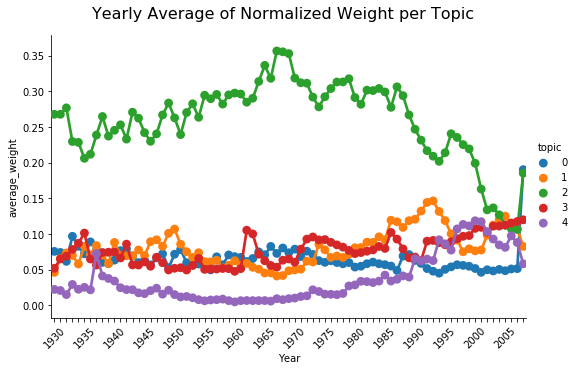

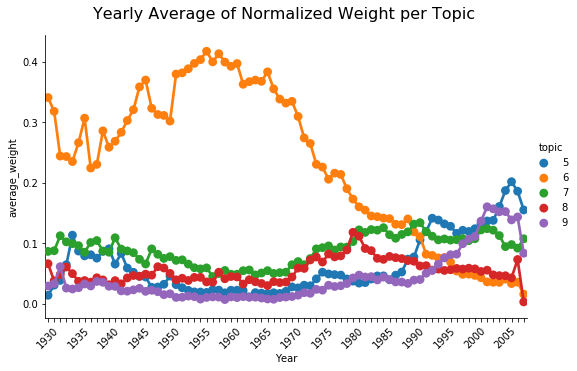

In [33]:
for i in range(0, number_topic, 5):
    dfs = dtm_time[(dtm_time['topic'] >= i) & (dtm_time['topic'] < i +5 )]
    create_pointplot(dfs, 'average_weight', hue="topic",
                title="Yearly Average of Normalized Weight per Topic")
